In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import finite
import timesteppers
from IPython.display import display, clear_output
import scipy.sparse.linalg as spla
from scipy import sparse

In [ ]:
# plot function 

# 2D 二维网格上的标量场 
def plot_2D_field(xm, ym, data):
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    pcm = ax.pcolormesh(xm, ym, data)
    ax.set_aspect(1)
    fig.colorbar(pcm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.tight_layout()

# 绘制矩阵（算子矩阵），取log值展示幅制
def plot_2D(matrix):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.tight_layout()

## Introduction

I've made some changes to our files so we can solve equations in multiple spatial dimensions. Now you can make multiple `Grid`s and put them together into a `Domain`.

In [ ]:
# 初始化网格和计算域
N = 100
# 创建一个均匀周期性网格
grid_x = finite.UniformPeriodicGrid(N, 2*np.pi)
grid_y = finite.UniformPeriodicGrid(N, 2*np.pi)

# Domain 用来管理多维网格的对象，允许多个方向上创建网格
domain = finite.Domain((grid_x, grid_y))
x, y = domain.values()
xm, ym = domain.plotting_arrays()

# 创建一些空的网格数据u
u = np.zeros(domain.shape)

u.shape

(100, 100)

In [4]:
x.shape

(100, 1)

When you make derivative operators, you now need to specify the direction the derivative is being taken in.

In [ ]:
# 创建查分算子dx和dy，分别用于x方向和y方向的导数
dx = finite.DifferenceUniformGrid(1, 2, grid_x, axis=0)
dy = finite.DifferenceUniformGrid(1, 2, grid_y, axis=1)

<ufunc 'solve1'>
<ufunc 'solve1'>


/opt/miniconda3/envs/446-1/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# 初始场u
u[:] = np.sin(x) + np.cos(y)

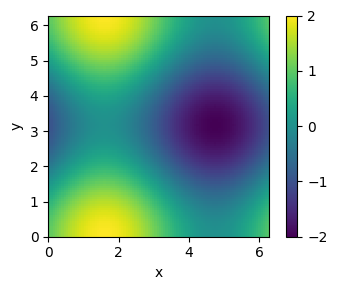

In [7]:
plot_2D_field(xm,ym,u)

In [8]:
dudy = dy @ u

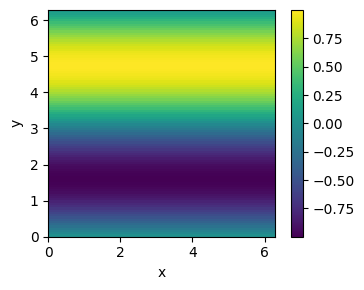

In [9]:
plot_2D_field(xm,ym,dudy)

## Advection Problem 对流问题

Now we're going to do a simple advection problem. We will solve
$$\partial_t c + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} c = 0$$
Here $\boldsymbol{u}=(u, v)$ is a constant advection velocity. We will solve this problem using an explicit method.

In [ ]:
class Advection:
    
    def __init__(self, c, u, v, dx, dy):
        self.X = timesteppers.StateVector([c]) # 标量场c，
        N = len(u)
        self.M = sparse.eye(N, N)
        self.L = sparse.csr_matrix((N, N))
        # 系统右侧，计算导数的离散近似
        self.F = lambda X: -u * (dx @ X.data) - v * (dy @ X.data)

In [ ]:
N = 100
grid_x = finite.UniformPeriodicGrid(N, 2*np.pi)
grid_y = finite.UniformPeriodicGrid(N, 2*np.pi)
domain = finite.Domain((grid_x, grid_y))
x, y = domain.values()
xm, ym = domain.plotting_arrays()


c = np.zeros(domain.shape)
u = np.zeros(domain.shape)
v = np.zeros(domain.shape)
# 初始条件是一个二维高斯峰值分布，位于中心
IC = np.exp(- ( (x-np.pi)**2 + (y-np.pi)**2 )*8 )
c[:] = IC
# u,v 都为1，表示两个方向上都有均匀的对流速度
u[:] = 1 
v[:] = 1

dx = finite.DifferenceUniformGrid(1, 4, grid_x, 0)
dy = finite.DifferenceUniformGrid(1, 4, grid_y, 1)

advect = Advection(c, u, v, dx, dy)

<ufunc 'solve1'>
<ufunc 'solve1'>


In [34]:
ts = timesteppers.RK22(advect)
alpha = 0.3
dt = grid_x.dx*alpha

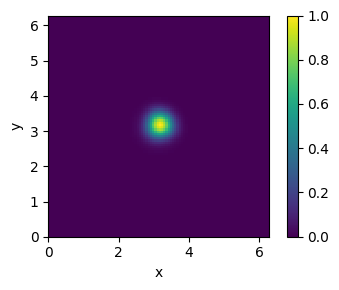

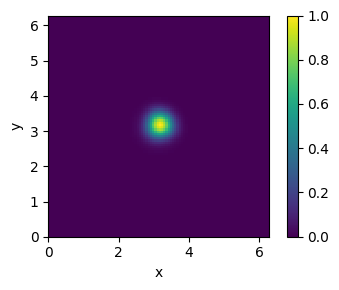

In [35]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
pcm = ax.pcolormesh(xm, ym, c.data)
ax.set_aspect(1)
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()
while ts.t < 2*np.pi:
    ts.step(dt)
    if ts.iter % 10 == 0:
        pcm.set_array(np.ravel(c.data))
        clear_output(wait=True)
        display(fig)

## Implicit Timestepping 隐式时间步进与洗漱矩阵

Implicit timestepping is a bit more complicated in 2D. We need to think about the matrix form of our operators.

In [36]:
#N = 30
N = 10
grid_x = finite.UniformPeriodicGrid(N, 2*np.pi)
grid_y = finite.UniformPeriodicGrid(N, 2*np.pi)
domain = finite.Domain((grid_x, grid_y))
x, y = domain.values()

In [37]:
d2x = finite.DifferenceUniformGrid(2, 2, grid_x, 0)
d2y = finite.DifferenceUniformGrid(2, 2, grid_y, 1)
I = sparse.eye(N, N)

<ufunc 'solve1'>
<ufunc 'solve1'>


/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_13893/678420383.py:16: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


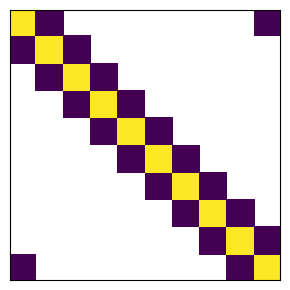

In [39]:
plot_2D(d2y.matrix.toarray())

In [ ]:
# 计算 Kronecker 积，从而生成用于二维拉普拉斯算子的稀疏矩阵。
d2y_full = sparse.kron(I, d2y.matrix)

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_13893/678420383.py:16: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


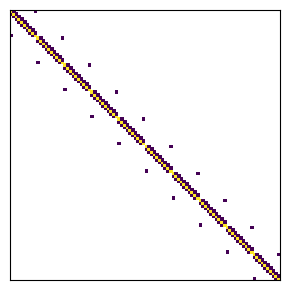

In [41]:
plot_2D(d2y_full.toarray())

In [42]:
d2x_full = sparse.kron(d2x.matrix, I)

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_13893/678420383.py:16: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


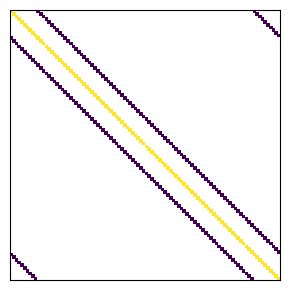

In [43]:
plot_2D(d2x_full.toarray())

In [44]:
LHS = sparse.kron(I, I) - d2x_full - d2y_full
#LHS = - d2x_full - d2y_full

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_13893/678420383.py:16: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


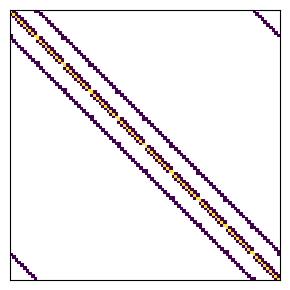

In [45]:
plot_2D(LHS.toarray())

In [ ]:
# 左端矩阵，代表一个离散的拉普拉斯算子加上单位矩阵
LHS

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 500 stored elements and shape (100, 100)>

In [ ]:
# LU 分解
LU = sparse.linalg.splu(LHS.tocsc(), permc_spec='NATURAL')

/var/folders/8j/kcmh8b0d37lgd3dff3rz5wsc0000gn/T/ipykernel_13893/678420383.py:16: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


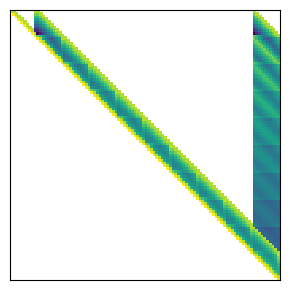

In [48]:
plot_2D(LU.U.toarray())

In [49]:
LU.U

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 1817 stored elements and shape (100, 100)>

In [50]:
LU.U

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 1817 stored elements and shape (100, 100)>

In [64]:
52257/1816

28.775881057268723